In [12]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [52]:
batch_size = 32
img_size = 177
base_dir = 'dataset/damage'

training_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=100,
  image_size=(img_size, img_size),
  batch_size=batch_size)

validation_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 485 files belonging to 1 classes.
Using 388 files for training.
Found 485 files belonging to 1 classes.
Using 97 files for validation.


In [51]:
shape = (1, 177, 177, 3)
x_train_t = np.zeros(shape)
for x, y in training_set:
  x_train_t = np.concatenate([x_train_t, x])
x_train = x_train_t[1:]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 177 and the array at index 1 has size 32

In [38]:
shape = (1,32,32,3)
x_test_t = np.zeros(shape)
for x, y in validation_set:
  x_test_t = np.concatenate([x_test_t, x])
x_test = x_test_t[1:]

In [23]:
# x_train = np.array([])
# for x, y in training_set:
#   x_train = np.concatenate([x])

# x_test = np.array([])
# for x, y in validation_set:
#   x_test = np.concatenate([x])

['resize_below_200']


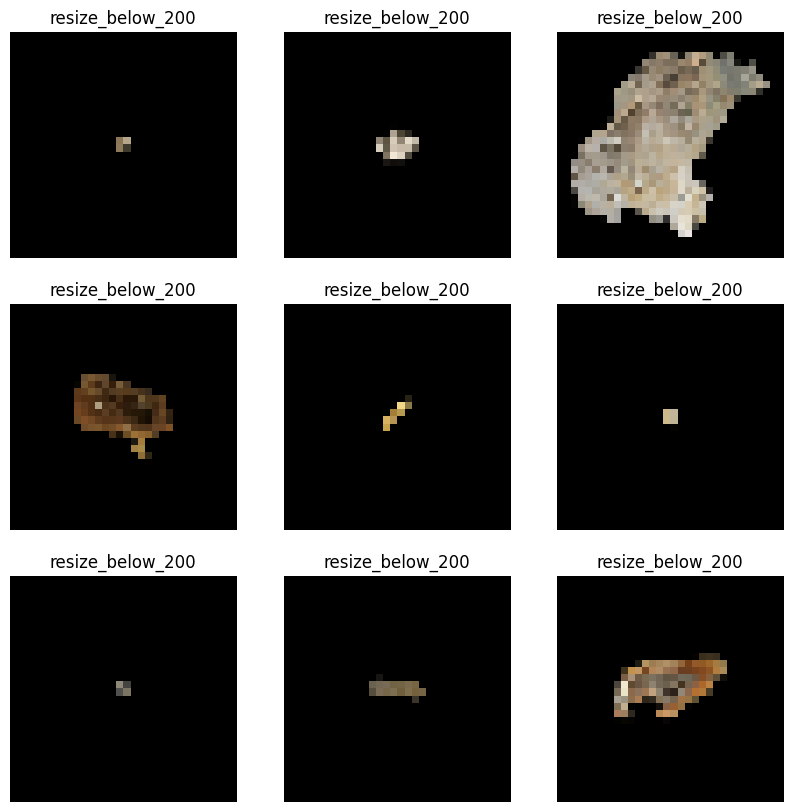

In [39]:
class_names = training_set.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [42]:
# Define input shape and latent dimension
latent_dim = 2
input_shape = (img_size, img_size, 3)
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [43]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z = Lambda(sampling)([z_mean, z_log_var])

In [44]:
# Decoder network
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [45]:
num_features = shape_before_flattening[1] * shape_before_flattening[2] * shape_before_flattening[3]
num_features = 4096

In [46]:
# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [47]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               599396    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         371363    
                                                                 
Total params: 970,759
Trainable params: 970,759
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Define the VAE loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
B = 1000
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [49]:
vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")

In [50]:
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=500, batch_size=32, validation_data=(x_test, None))

Epoch 1/500


13/13 [==============================] - 10s 458ms/step - loss: 24490242.0000 - kl_loss: 25668838.0000 - reconstruction_loss: 549.1172 - val_loss: 105257.3203 - val_kl_loss: 6.7367 - val_reconstruction_loss: 105.2513
Epoch 2/500
13/13 [==============================] - 0s 16ms/step - loss: 41508.8086 - kl_loss: 4.1596 - reconstruction_loss: 41.5049 - val_loss: 18483.5039 - val_kl_loss: 0.0587 - val_reconstruction_loss: 18.4834
Epoch 3/500
13/13 [==============================] - 0s 17ms/step - loss: 19799.1680 - kl_loss: 0.0794 - reconstruction_loss: 19.7991 - val_loss: 17673.9473 - val_kl_loss: 0.1135 - val_reconstruction_loss: 17.6738
Epoch 4/500
13/13 [==============================] - 0s 15ms/step - loss: 19430.3535 - kl_loss: 0.1419 - reconstruction_loss: 19.4302 - val_loss: 17620.3184 - val_kl_loss: 0.1689 - val_reconstruction_loss: 17.6201
Epoch 5/500
 9/13 [===================>..........] - ETA: 0s - loss: 19830.0293 - kl_loss: 0.1811 - reconstruction_loss: 19.8298

KeyboardInterrupt: 

In [45]:
from tensorflow.keras.models import Sequential, save_model
vae.save('saved_model/model.h5')

In [66]:
reconstructed_vae= keras.models.load_model("saved_model/model.h5'")

NameError: name 'loaded_model' is not defined

4/4 [==============================] - 0s 44ms/step


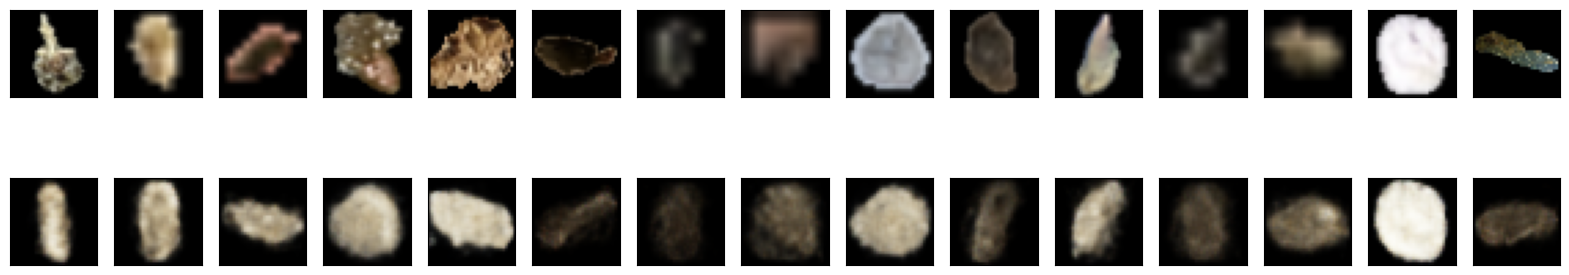

In [49]:
import matplotlib.pyplot as plt
# Convert the predictions into images
decoded_imgs = vae.predict(x_test)
# Display the original and reconstructed images
n = 15 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

4/4 [==============================] - 0s 44ms/step


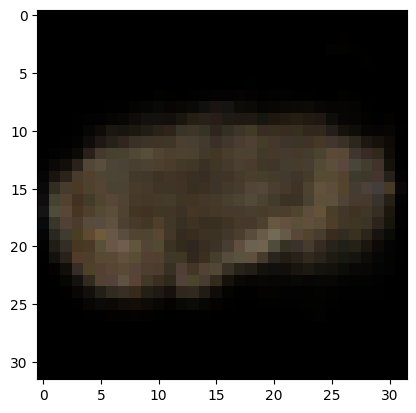

In [50]:
from PIL import Image
decoded_imgs = vae.predict(x_test)
for i in range(15):
    arr = decoded_imgs[i].reshape(img_size, img_size,3)
    plt.imshow(arr)
    plt.imsave(f'gen_img/{i}.png', arr)

1/1 [==============================] - 0s 302ms/step


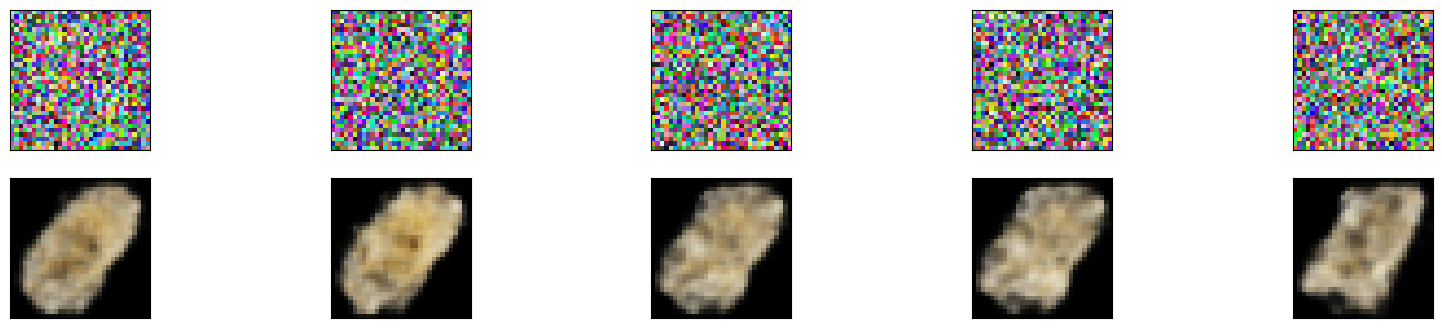

In [48]:
import matplotlib.pyplot as plt
# Convert the predictions into images
num_samples = 10
random_latent_vectors  = np.random.random((num_samples, img_size, img_size, 3))

decoded_imgs = vae.predict(random_latent_vectors)
# Display the original and reconstructed images
n = 5 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(random_latent_vectors[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [57]:
from PIL import Image
import os

for img in os.listdir('dataset/damage'):
    image = Image.open(f'dataset/damage/{img}')
    rgb_image = image.convert("RGB")
    width, height = rgb_image.size
    res = rgb_image.resize((32, 32))
    # Image.fromarray(B)
    res.save(f'resize_32/{img}')



In [11]:
import os 
from PIL import Image

dim = []
for img in os.listdir('dataset\damage_below_200'):
    img_path = os.path.join('dataset\damage_below_200', img)
    image = Image.open(img_path)
    width, height = image.size
    if width < 10:
        print(img)
    dim.append(width)

103_4.png
103_5.png
107_1.png
109_3.png
120_3.png
120_5.png
120_6.png
121_1.png
121_2.png
13_1.png
46_10.png
46_11.png
46_12.png
46_3.png
46_4.png
46_7.png
69_2.png
69_3.png
69_4.png
72_0.png
73_0.png
73_1.png
75_0.png
75_1.png


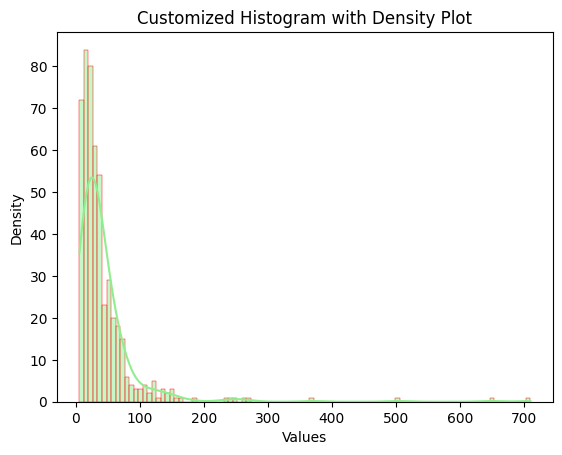

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
 
# Creating a customized histogram with a density plot
sns.histplot(dim, bins=100, kde=True, color='lightgreen', edgecolor='red')
 
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Customized Histogram with Density Plot')
 
# Display the plot
plt.show()

In [ ]:
for img in os.listdir('dataset\damage'):
    image = Image.open(f'dataset\damage/{img}')
    rgb_image = image.convert("RGB")
    np.array(rgb_image)

In [8]:
import numpy as np
from PIL import Image
import os

for img in os.listdir('dataset/damage_below_200'):
    image = Image.open(f'dataset/damage_below_200/{img}')
    rgb_image = image.convert("RGB")
    image_a = np.array(rgb_image)

    target_dim = 177

    # Calculate padding size
    pad_size = (target_dim - image_a.shape[0]) // 2

    # Create a blank canvas with black pixels
    canvas = np.zeros((target_dim, target_dim, 3), dtype=np.uint8)

    # Calculate coordinates for placing image A on the canvas
    start_x = pad_size
    start_y = pad_size
    end_x = start_x + image_a.shape[0]
    end_y = start_y + image_a.shape[1]

    # Place image A on the canvas
    canvas[start_x:end_x, start_y:end_y, :] = image_a

    # Convert NumPy array to PIL Image
    result_image = Image.fromarray(canvas)

    result_image.save(f'dataset/resize_below_200/{img}')



In [33]:
for img in os.listdir('dataset/damage/resize_below_200'):
    image = Image.open(f'dataset/damage/resize_below_200/{img}')
    print(np.array(image).shape)
    

(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 177, 3)
(177, 